In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
#from xgboost import XGBClassifier
from scipy import stats

import warnings
warnings.filterwarnings('ignore')


## Import Data

In [4]:
# Read the data into a data frame
data = pd.read_csv("credit_risk_dataset.csv")

In [99]:
print('Number of rows:',data.shape[0])
print('Number of columns:',data.shape[1])

Number of rows: 32581
Number of columns: 12


In [100]:
data[data.duplicated()].shape #terdapat baris yang duplicate sebanyak 165 baris, agar model lebih baik, maka hapus baris duplicate tsb

(165, 12)

In [101]:
data = data[~data.duplicated()]

In [102]:
print('Number of rows after deleting duplicate rows:',data.shape[0])
print('Number of columns after deleting duplicate rows:',data.shape[1])

Number of rows after deleting duplicate rows: 32416
Number of columns after deleting duplicate rows: 12


In [103]:
data.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [5]:
data['person_home_ownership'].unique()

array(['RENT', 'OWN', 'MORTGAGE', 'OTHER'], dtype=object)

In [6]:
data['loan_intent'].unique()

array(['PERSONAL', 'EDUCATION', 'MEDICAL', 'VENTURE', 'HOMEIMPROVEMENT',
       'DEBTCONSOLIDATION'], dtype=object)

In [7]:
data['loan_grade'].unique()

array(['D', 'B', 'C', 'A', 'E', 'F', 'G'], dtype=object)

## Data Exploration 

In [104]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32416 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32416 non-null  int64  
 1   person_income               32416 non-null  int64  
 2   person_home_ownership       32416 non-null  object 
 3   person_emp_length           31529 non-null  float64
 4   loan_intent                 32416 non-null  object 
 5   loan_grade                  32416 non-null  object 
 6   loan_amnt                   32416 non-null  int64  
 7   loan_int_rate               29321 non-null  float64
 8   loan_status                 32416 non-null  int64  
 9   loan_percent_income         32416 non-null  float64
 10  cb_person_default_on_file   32416 non-null  object 
 11  cb_person_cred_hist_length  32416 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.2+ MB


In [105]:
y = data['loan_status'].copy()

In [106]:
num_columns = data.select_dtypes(include='number').columns.tolist()
cat_columns = data.select_dtypes(include='object').columns.tolist()

print("Total numerical columns :", len(num_columns))
print("Total categorical columns :", len(cat_columns))


Total numerical columns : 8
Total categorical columns : 4


In [107]:
del num_columns[5]

In [108]:
num_columns

['person_age',
 'person_income',
 'person_emp_length',
 'loan_amnt',
 'loan_int_rate',
 'loan_percent_income',
 'cb_person_cred_hist_length']

In [109]:
cat_columns

['person_home_ownership',
 'loan_intent',
 'loan_grade',
 'cb_person_default_on_file']

In [110]:
num_idx = [data.columns.get_loc(c) for c in num_columns]
cat_idx = [data.columns.get_loc(c) for c in cat_columns]


In [111]:
data.columns[num_idx]

Index(['person_age', 'person_income', 'person_emp_length', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length'],
      dtype='object')

In [112]:
data.columns[cat_idx]

Index(['person_home_ownership', 'loan_intent', 'loan_grade',
       'cb_person_default_on_file'],
      dtype='object')

### Simple Statistics

In [113]:
data.describe(include='number').T

,count,mean,std,min,25%,50%,75%,max
person_age,32416.0,27.747008,6.354100,20.00,23.00,26.00,30.00,144.00
person_income,32416.0,66091.640826,62015.580269,4000.00,38542.00,55000.00,79218.00,6000000.00
person_emp_length,31529.0,4.790510,4.145490,0.00,2.00,4.00,7.00,123.00
loan_amnt,32416.0,9593.845632,6322.730241,500.00,5000.00,8000.00,12250.00,35000.00
loan_int_rate,29321.0,11.017265,3.241680,5.42,7.90,10.99,13.47,23.22
loan_status,32416.0,0.218688,0.413363,0.00,0.00,0.00,0.00,1.00
loan_percent_income,32416.0,0.170250,0.106812,0.00,0.09,0.15,0.23,0.83
cb_person_cred_hist_length,32416.0,5.811297,4.059030,2.00,3.00,4.00,8.00,30.00


In [114]:
data.describe(include='object').T

,count,unique,top,freq
person_home_ownership,32416,4,RENT,16378
loan_intent,32416,6,EDUCATION,6411
loan_grade,32416,7,A,10703
cb_person_default_on_file,32416,2,N,26686


In [115]:
y.value_counts()

# 0 for non default, and 1 for default

0    25327
1     7089
Name: loan_status, dtype: int64

###  Check missing values

In [116]:
data.isnull().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              887
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3095
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

There are columns with missing value, person_emp_length and loan_int_rate. Person_emp_length is employment length (in  years), and the minimum value is 0, so if there is missing value in this column, it literally means missing value. Maybe because of no observation. Loan_int_rate is interest rate, i think, value in this column should not be empty (every loan has interest rate), so it literally means missing value, maybe because of no observation.

Dipilih metode woe untuk handling missing value, karena apabila row dengan missing value kita hapus, nanti akan terjadi eror ketika input data pada development. Woe ini akan dilakukan juga saat development.

### Check outlier

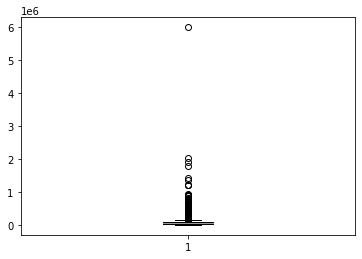

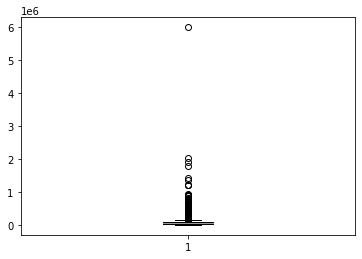

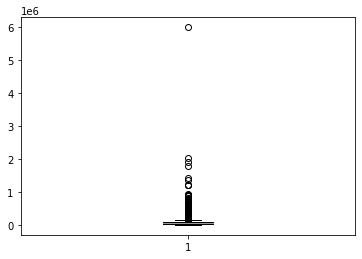

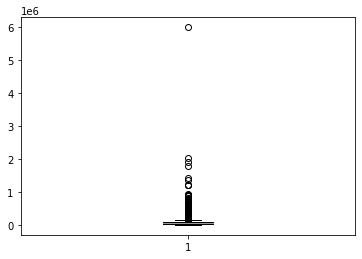

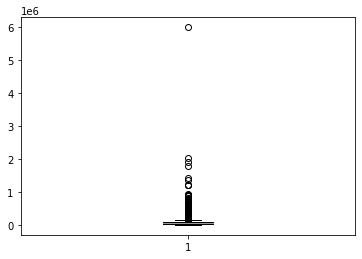

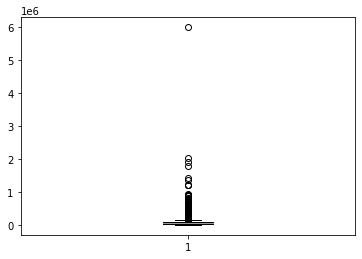

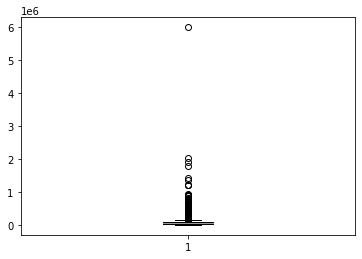

In [117]:
for i in list(range(len(num_columns))) :
    plt.boxplot(data[num_columns[1]])
    plt.show()

Semua variabel numerik memiliki outlier. Untuk menghandle outlier tersebut, dipilih metode woe. Jadi metode woe disini digunakan untuk menghandle missing value sekaligus outliers.

### Correlated features

In [118]:
import matplotlib.pyplot as plt
import seaborn as sns


def plot_correlation(data):
    corr = data.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))

    fig = plt.figure(figsize=(10, 10))

    ax = sns.heatmap(
        corr, 
        mask=mask,
        vmin=-1, vmax=1, center=0,
        cmap='coolwarm',
        square=True,
        linewidths=0.3,
        annot=True,
        fmt=".2f",
        annot_kws={"size": 8},
        cbar_kws={"shrink": .5}
    )

    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right'
    )

    ax.set_title("Correlation", size=14)

    plt.show()

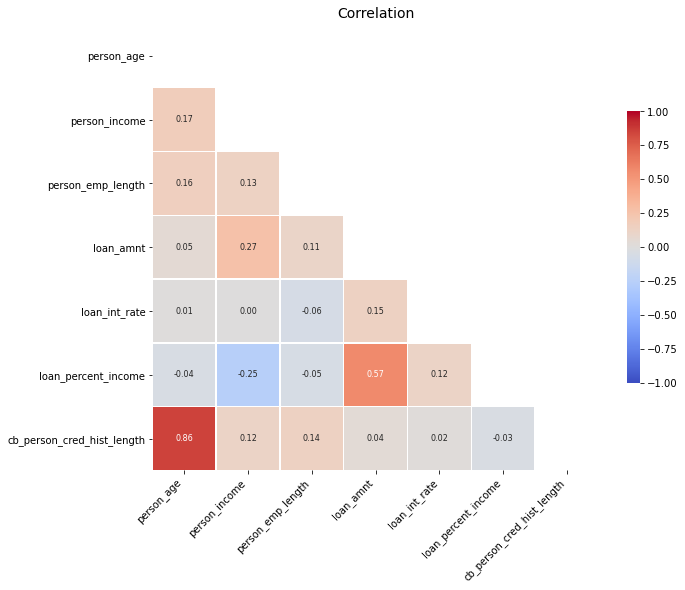

In [119]:
plot_correlation(data[num_columns])

person_age and cb_person_cred_hist_length have strong correlation

###  Data Preprocess

In [120]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(drop='first')
ohe.fit(data[cat_columns])

data_ohe = ohe.transform(data[cat_columns]).toarray()

In [121]:
data_ohe

array([[0., 0., 1., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

In [122]:
column_name_ohe = ohe.get_feature_names(cat_columns)
column_name_ohe

array(['person_home_ownership_OTHER', 'person_home_ownership_OWN',
       'person_home_ownership_RENT', 'loan_intent_EDUCATION',
       'loan_intent_HOMEIMPROVEMENT', 'loan_intent_MEDICAL',
       'loan_intent_PERSONAL', 'loan_intent_VENTURE', 'loan_grade_B',
       'loan_grade_C', 'loan_grade_D', 'loan_grade_E', 'loan_grade_F',
       'loan_grade_G', 'cb_person_default_on_file_Y'], dtype=object)

In [123]:
data_one_hot_encode = pd.DataFrame(data_ohe, columns = column_name_ohe, index = data[cat_columns].index).astype(int)

In [124]:
data_one_hot_encode.head()

,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_Y
0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1
1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
3,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0
4,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1


In [125]:
data = pd.concat([data, data_one_hot_encode], axis = 1).reset_index(drop = True)

In [126]:
data.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,...,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_Y
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,...,0,1,0,0,0,1,0,0,0,1
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,...,0,0,0,1,0,0,0,0,0,0
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,...,1,0,0,0,1,0,0,0,0,0
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,...,1,0,0,0,1,0,0,0,0,0
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,...,1,0,0,0,1,0,0,0,0,1


In [127]:
import pickle

OneHotEncoder = 'OHE-1.0.0.pkl'
ColumnName = 'COL-NAME1.0.0.pkl'

with open(OneHotEncoder, 'wb') as f:
    pickle.dump(ohe, f)
    
with open(ColumnName, 'wb') as f:
    pickle.dump(cat_columns, f)

### WOE 

In [128]:
# person age
feature = 'person_age'
binning=[-float("inf"), 20, 25, 30, float("inf")]

bin_feature = pd.cut(data[feature], bins=binning).values.add_categories('Nan').fillna('Nan')
data_woe_iv = (pd.crosstab(bin_feature,y,normalize='columns')
             .assign(woe=lambda datax: np.log(datax[1] / datax[0]))
             .assign(iv=lambda datax: np.sum(datax['woe']*
                                           (datax[1]-datax[0]))))

data_woe_iv


loan_status,0,1,woe,iv
row_0,,,,
"(-inf, 20.0]",0.000513,0.000282,-0.598475,0.005105
"(20.0, 25.0]",0.462155,0.497249,0.073191,0.005105
"(25.0, 30.0]",0.294468,0.278036,-0.057420,0.005105
"(30.0, inf]",0.242863,0.224432,-0.078925,0.005105


In [129]:
# person_age
data[f'{feature}_WOE'] = pd.cut(data[feature], bins=binning, labels=[-0.598, 0.073, -0.057, -0.007])
data[f'{feature}_WOE'] = data[f'{feature}_WOE'].values.add_categories('Nan').fillna('Nan') 
data[f'{feature}_WOE'] = data[f'{feature}_WOE'].replace('Nan', 0)
data[f'{feature}_WOE'] = data[f'{feature}_WOE'].astype(float)

In [130]:
# loan_int_rate
feature = 'loan_int_rate'
binning=[-float("inf"), 6, 10, 15, float("inf")]

bin_feature = pd.cut(data[feature], bins=binning).values.add_categories('Nan').fillna('Nan')
data_woe_iv = (pd.crosstab(bin_feature,y,normalize='columns')
             .assign(woe=lambda datax: np.log(datax[1] / datax[0]))
             .assign(iv=lambda datax: np.sum(datax['woe']*
                                           (datax[1]-datax[0]))))

data_woe_iv

loan_status,0,1,woe,iv
row_0,,,,
"(-inf, 6.0]",0.049828,0.012131,-1.412779,0.560435
"(6.0, 10.0]",0.358945,0.166737,-0.766750,0.560435
"(10.0, 15.0]",0.437517,0.449429,0.026861,0.560435
"(15.0, inf]",0.056817,0.281281,1.599521,0.560435
Nan,0.096893,0.090422,-0.069118,0.560435


In [131]:
data[f'{feature}_WOE'] = pd.cut(data[feature], bins=binning, labels=[-1.412, -0.766, 0.026, 1.599])
data[f'{feature}_WOE'] = data[f'{feature}_WOE'].values.add_categories('Nan').fillna('Nan') 
data[f'{feature}_WOE'] = data[f'{feature}_WOE'].replace('Nan', 0)
data[f'{feature}_WOE'] = data[f'{feature}_WOE'].astype(float)

In [132]:
# loan_percent_income
feature = 'loan_percent_income'
binning=[-float("inf"), 0.1, 0.3, 0.6, float("inf")]

bin_feature = pd.cut(data[feature], bins=binning).values.add_categories('Nan').fillna('Nan')
data_woe_iv = (pd.crosstab(bin_feature,y,normalize='columns')
             .assign(woe=lambda datax: np.log(datax[1] / datax[0]))
             .assign(iv=lambda datax: np.sum(datax['woe']*
                                           (datax[1]-datax[0]))))

data_woe_iv

loan_status,0,1,woe,iv
row_0,,,,
"(-inf, 0.1]",0.363407,0.172944,-0.742555,0.899409
"(0.1, 0.3]",0.592016,0.447595,-0.279646,0.899409
"(0.3, 0.6]",0.044143,0.373960,2.136722,0.899409
"(0.6, inf]",0.000434,0.005501,2.538993,0.899409


In [133]:
data[f'{feature}_WOE'] = pd.cut(data[feature], bins=binning, labels=[-0.742, -0.279, 2.136, 2.538])
data[f'{feature}_WOE'] = data[f'{feature}_WOE'].values.add_categories('Nan').fillna('Nan') 
data[f'{feature}_WOE'] = data[f'{feature}_WOE'].replace('Nan', 0)
data[f'{feature}_WOE'] = data[f'{feature}_WOE'].astype(float)

In [134]:
# person_income
feature = 'person_income'
binning=[-float("inf"), 10000, 38452, 55000,79218, 140298, float("inf")]

bin_feature = pd.cut(data[feature], bins=binning).values.add_categories('Nan').fillna('Nan')
data_woe_iv = (pd.crosstab(bin_feature,y,normalize='columns')
             .assign(woe=lambda datax: np.log(datax[1] / datax[0]))
             .assign(iv=lambda datax: np.sum(datax['woe']*
                                           (datax[1]-datax[0]))))

data_woe_iv

loan_status,0,1,woe,iv
row_0,,,,
"(-inf, 10000.0]",0.000513,0.011003,3.065086,0.454521
"(10000.0, 38452.0]",0.191535,0.442658,0.837728,0.454521
"(38452.0, 55000.0]",0.254827,0.247990,-0.027197,0.454521
"(55000.0, 79218.0]",0.262368,0.193962,-0.302084,0.454521
"(79218.0, 140298.0]",0.238086,0.084074,-1.040935,0.454521
"(140298.0, inf]",0.052671,0.020313,-0.952797,0.454521


In [135]:
data[f'{feature}_WOE'] = pd.cut(data[feature], bins=binning, labels=[3.065, 0.837, -0.027, -0.302, -1.040, -0.952])
data[f'{feature}_WOE'] = data[f'{feature}_WOE'].values.add_categories('Nan').fillna('Nan') 
data[f'{feature}_WOE'] = data[f'{feature}_WOE'].replace('Nan', 0)
data[f'{feature}_WOE'] = data[f'{feature}_WOE'].astype(float)

In [136]:
# loan_amnt
feature = 'loan_amnt'
binning=[-float("inf"), 1000, 10000, 15000, 23125, float("inf")]

bin_feature = pd.cut(data[feature], bins=binning).values.add_categories('Nan').fillna('Nan')
data_woe_iv = (pd.crosstab(bin_feature,y,normalize='columns')
             .assign(woe=lambda datax: np.log(datax[1] / datax[0]))
             .assign(iv=lambda datax: np.sum(datax['woe']*
                                           (datax[1]-datax[0]))))

data_woe_iv

loan_status,0,1,woe,iv
row_0,,,,
"(-inf, 1000.0]",0.010424,0.008887,-0.159488,0.07195
"(1000.0, 10000.0]",0.673471,0.568345,-0.169716,0.07195
"(10000.0, 15000.0]",0.184980,0.198335,0.069710,0.07195
"(15000.0, 23125.0]",0.088838,0.138666,0.445250,0.07195
"(23125.0, inf]",0.042287,0.085767,0.707154,0.07195


In [137]:
data[f'{feature}_WOE'] = pd.cut(data[feature], bins=binning, labels=[-0.159, -0.169, 0.069, 0.445, 0.707])
data[f'{feature}_WOE'] = data[f'{feature}_WOE'].values.add_categories('Nan').fillna('Nan') 
data[f'{feature}_WOE'] = data[f'{feature}_WOE'].replace('Nan', 0)
data[f'{feature}_WOE'] = data[f'{feature}_WOE'].astype(float)

In [138]:
# person_emp_length 2 4 7 123
feature = 'person_emp_length'
binning = [-float("inf"), 4, 10, float("inf")]

bin_feature = pd.cut(data[feature], bins=binning).values.add_categories('Nan').fillna('Nan')
data_woe_iv = (pd.crosstab(bin_feature,y,
                      normalize='columns')
             .assign(woe=lambda datax: np.log(datax[1] / datax[0]))
             .assign(iv=lambda datax: np.sum(datax['woe']*
                                           (datax[1]-datax[0]))))

data_woe_iv

loan_status,0,1,woe,iv
row_0,,,,
"(-inf, 4.0]",0.508706,0.597545,0.160960,0.050008
"(4.0, 10.0]",0.370869,0.295951,-0.225653,0.050008
"(10.0, inf]",0.096498,0.066864,-0.366857,0.050008
Nan,0.023927,0.039639,0.504801,0.050008


In [139]:
data[f'{feature}_WOE'] = pd.cut(data[feature], bins=binning, labels=[0.160, -0.225, -0.366])
data[f'{feature}_WOE'] = data[f'{feature}_WOE'].values.add_categories('Nan').fillna('Nan') 
data[f'{feature}_WOE'] = data[f'{feature}_WOE'].replace('Nan', 0)
data[f'{feature}_WOE'] = data[f'{feature}_WOE'].astype(float)

In [140]:
# cb_person_cred_hist_length 2 3 4 8 30
feature = 'cb_person_cred_hist_length'
binning = [-float("inf"), 3, 4, 8, 15.5, float("inf")]

bin_feature = pd.cut(data[feature], bins=binning).values.add_categories('Nan').fillna('Nan')
data_woe_iv = (pd.crosstab(bin_feature,y,
                      normalize='columns')
             .assign(woe=lambda datax: np.log(datax[1] / datax[0]))
             .assign(iv=lambda datax: np.sum(datax['woe']*
                                           (datax[1]-datax[0]))))

data_woe_iv

loan_status,0,1,woe,iv
row_0,,,,
"(-inf, 3.0]",0.359498,0.384398,0.066971,0.004093
"(3.0, 4.0]",0.180163,0.185922,0.031462,0.004093
"(4.0, 8.0]",0.235401,0.219072,-0.071891,0.004093
"(8.0, 15.5]",0.189718,0.175765,-0.076392,0.004093
"(15.5, inf]",0.035219,0.034843,-0.010751,0.004093


In [141]:
data[f'{feature}_WOE'] = pd.cut(data[feature], bins=binning, labels=[0.066, 0.031, -0.071, -0.076, -0.010])
data[f'{feature}_WOE'] = data[f'{feature}_WOE'].values.add_categories('Nan').fillna('Nan') 
data[f'{feature}_WOE'] = data[f'{feature}_WOE'].replace('Nan', 0)
data[f'{feature}_WOE'] = data[f'{feature}_WOE'].astype(float) 

In [142]:
data.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,...,loan_grade_F,loan_grade_G,cb_person_default_on_file_Y,person_age_WOE,loan_int_rate_WOE,loan_percent_income_WOE,person_income_WOE,loan_amnt_WOE,person_emp_length_WOE,cb_person_cred_hist_length_WOE
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,...,0,0,1,0.073,1.599,2.136,-0.302,0.707,-0.366,0.066
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,...,0,0,0,0.073,0.026,-0.742,3.065,-0.159,-0.225,0.066
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,...,0,0,0,0.073,0.026,2.136,3.065,-0.169,0.160,0.066
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,...,0,0,0,0.073,1.599,2.136,-0.302,0.707,0.160,0.066
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,...,0,0,1,0.073,0.026,2.136,-0.027,0.707,-0.225,0.031


### Handling Outlier 

In [143]:
woe = {
    'person_age' : {'binning':[-float("inf"), 20, 25, 30, float("inf")], 'labels':[-0.598, 0.073, -0.057, -0.007],'nan':0},
    'loan_int_rate' : {'binning':[-float("inf"), 6, 10, 15, float("inf")], 'labels':[-1.412, -0.766, 0.026, 1.599],'nan':0},
    'loan_percent_income' : {'binning':[-float("inf"), 0.1, 0.3, 0.6, float("inf")], 'labels':[-0.742, -0.279, 2.136, 2.538],'nan':0},
    'person_income' : {'binning':[-float("inf"), 10000, 38452, 55000,79218, 140298, float("inf")], 'labels':[3.065, 0.837, -0.027, -0.302, -1.040, -0.952],'nan':0},
    'loan_amnt' : {'binning':[-float("inf"), 1000, 10000, 15000, 23125, float("inf")], 'labels':[-0.159, -0.169, 0.069, 0.445, 0.707],'nan':0},
    'person_emp_length' : {'binning':[-float("inf"), 4, 10, float("inf")], 'labels':[0.160, -0.225, -0.366],'nan':0},
    'cb_person_cred_hist_length' : {'binning':[-float("inf"), 3, 4, 8, 15.5, float("inf")], 'labels':[0.066, 0.031, -0.071, -0.076, -0.010],'nan':0}    
}
    

In [144]:
data.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,...,loan_grade_F,loan_grade_G,cb_person_default_on_file_Y,person_age_WOE,loan_int_rate_WOE,loan_percent_income_WOE,person_income_WOE,loan_amnt_WOE,person_emp_length_WOE,cb_person_cred_hist_length_WOE
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,...,0,0,1,0.073,1.599,2.136,-0.302,0.707,-0.366,0.066
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,...,0,0,0,0.073,0.026,-0.742,3.065,-0.159,-0.225,0.066
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,...,0,0,0,0.073,0.026,2.136,3.065,-0.169,0.160,0.066
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,...,0,0,0,0.073,1.599,2.136,-0.302,0.707,0.160,0.066
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,...,0,0,1,0.073,0.026,2.136,-0.027,0.707,-0.225,0.031


In [145]:
for feature, woe_info in woe.items():
    print('feature:', feature)
    data[f'{feature}_WOE'] = pd.cut(data[feature], bins = woe_info['binning'], labels = woe_info['labels'])
    data[f'{feature}_WOE'] = data[f'{feature}_WOE'].values.add_categories('Nan').fillna('Nan')
    data[f'{feature}_WOE'] = data[f'{feature}_WOE'].replace('Nan', woe_info['nan'])
    data[f'{feature}_WOE'] = data[f'{feature}_WOE'].astype(float)
    

feature: person_age
feature: loan_int_rate
feature: loan_percent_income
feature: person_income
feature: loan_amnt
feature: person_emp_length
feature: cb_person_cred_hist_length


In [146]:
DictWOE = 'WOE-1.0.0.pkl'

with open (DictWOE, 'wb') as f:
    pickle.dump(woe, f)

## Data Splitting 

Because of imbalance dataset, so we use stratify to splitting the dataset

In [147]:
data.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,...,loan_grade_F,loan_grade_G,cb_person_default_on_file_Y,person_age_WOE,loan_int_rate_WOE,loan_percent_income_WOE,person_income_WOE,loan_amnt_WOE,person_emp_length_WOE,cb_person_cred_hist_length_WOE
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,...,0,0,1,0.073,1.599,2.136,-0.302,0.707,-0.366,0.066
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,...,0,0,0,0.073,0.026,-0.742,3.065,-0.159,-0.225,0.066
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,...,0,0,0,0.073,0.026,2.136,3.065,-0.169,0.160,0.066
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,...,0,0,0,0.073,1.599,2.136,-0.302,0.707,0.160,0.066
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,...,0,0,1,0.073,0.026,2.136,-0.027,0.707,-0.225,0.031


In [148]:
from sklearn.model_selection import train_test_split

SEED = 42
train = data.drop('loan_status', axis=1)

X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.3, stratify=y, random_state=SEED)

print("Number of Train :", len(y_train), f"{round(len(y_train) / len(y) * 100, 2)}%")
print("Number of Test :", len(y_test), f"{round(len(y_test) / len(y) * 100, 2)}%")

Number of Train : 22691 70.0%
Number of Test : 9725 30.0%


In [149]:
print("Percentage of target in Train :", np.mean(y_train))
print("Percentage of target in Test :", np.mean(y_test))

Percentage of target in Train : 0.2186770085055749
Percentage of target in Test : 0.2187146529562982


In [150]:
X_train.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,...,loan_grade_F,loan_grade_G,cb_person_default_on_file_Y,person_age_WOE,loan_int_rate_WOE,loan_percent_income_WOE,person_income_WOE,loan_amnt_WOE,person_emp_length_WOE,cb_person_cred_hist_length_WOE
7126,25,51684,MORTGAGE,9.0,PERSONAL,D,4000,15.99,0.08,N,...,0,0,0,0.073,1.599,-0.742,-0.027,-0.169,-0.225,0.031
15645,22,90000,RENT,5.0,MEDICAL,B,15000,11.49,0.17,N,...,0,0,0,0.073,0.026,-0.279,-1.040,0.069,-0.225,0.031
7626,24,93500,RENT,2.0,VENTURE,C,6400,13.23,0.07,Y,...,0,0,1,0.073,0.026,-0.742,-1.040,-0.169,0.160,0.066
20390,27,49200,RENT,4.0,DEBTCONSOLIDATION,C,4800,14.65,0.10,N,...,0,0,0,-0.057,0.026,-0.742,-0.027,-0.169,0.160,-0.071
7969,23,49000,MORTGAGE,7.0,MEDICAL,D,5000,15.21,0.10,N,...,0,0,0,0.073,1.599,-0.742,-0.027,-0.169,-0.225,0.066


In [151]:
X_train.columns

Index(['person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_default_on_file',
       'cb_person_cred_hist_length', 'person_home_ownership_OTHER',
       'person_home_ownership_OWN', 'person_home_ownership_RENT',
       'loan_intent_EDUCATION', 'loan_intent_HOMEIMPROVEMENT',
       'loan_intent_MEDICAL', 'loan_intent_PERSONAL', 'loan_intent_VENTURE',
       'loan_grade_B', 'loan_grade_C', 'loan_grade_D', 'loan_grade_E',
       'loan_grade_F', 'loan_grade_G', 'cb_person_default_on_file_Y',
       'person_age_WOE', 'loan_int_rate_WOE', 'loan_percent_income_WOE',
       'person_income_WOE', 'loan_amnt_WOE', 'person_emp_length_WOE',
       'cb_person_cred_hist_length_WOE'],
      dtype='object')

In [152]:
X_train.sample(1).to_dict(orient = 'records')

[{'person_age': 22,
  'person_income': 48000,
  'person_home_ownership': 'RENT',
  'person_emp_length': 0.0,
  'loan_intent': 'DEBTCONSOLIDATION',
  'loan_grade': 'C',
  'loan_amnt': 14400,
  'loan_int_rate': 13.49,
  'loan_percent_income': 0.3,
  'cb_person_default_on_file': 'Y',
  'cb_person_cred_hist_length': 2,
  'person_home_ownership_OTHER': 0,
  'person_home_ownership_OWN': 0,
  'person_home_ownership_RENT': 1,
  'loan_intent_EDUCATION': 0,
  'loan_intent_HOMEIMPROVEMENT': 0,
  'loan_intent_MEDICAL': 0,
  'loan_intent_PERSONAL': 0,
  'loan_intent_VENTURE': 0,
  'loan_grade_B': 0,
  'loan_grade_C': 1,
  'loan_grade_D': 0,
  'loan_grade_E': 0,
  'loan_grade_F': 0,
  'loan_grade_G': 0,
  'cb_person_default_on_file_Y': 1,
  'person_age_WOE': 0.073,
  'loan_int_rate_WOE': 0.026,
  'loan_percent_income_WOE': -0.279,
  'person_income_WOE': -0.027,
  'loan_amnt_WOE': 0.069,
  'person_emp_length_WOE': 0.16,
  'cb_person_cred_hist_length_WOE': 0.066}]

In [153]:
raw_input = {
    'person_age': 27,
  'person_income': 110000,
  'person_home_ownership': 'MORTGAGE',
  'person_emp_length': 11.0,
  'loan_intent': 'HOMEIMPROVEMENT',
  'loan_grade': 'A',
  'loan_amnt': 3600,
  'loan_int_rate': 6.03,
  'loan_status': 0,
  'loan_percent_income': 0.03,
  'cb_person_default_on_file': 'N',
  'cb_person_cred_hist_length': 5,
}

In [154]:
pd.DataFrame.from_dict(raw_input, orient = 'index').T.replace({None : np.nan, "null" : np.nan, "" : np.nan})

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,27,110000,MORTGAGE,11.0,HOMEIMPROVEMENT,A,3600,6.03,0,0.03,N,5


In [155]:
X_train.columns

Index(['person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_default_on_file',
       'cb_person_cred_hist_length', 'person_home_ownership_OTHER',
       'person_home_ownership_OWN', 'person_home_ownership_RENT',
       'loan_intent_EDUCATION', 'loan_intent_HOMEIMPROVEMENT',
       'loan_intent_MEDICAL', 'loan_intent_PERSONAL', 'loan_intent_VENTURE',
       'loan_grade_B', 'loan_grade_C', 'loan_grade_D', 'loan_grade_E',
       'loan_grade_F', 'loan_grade_G', 'cb_person_default_on_file_Y',
       'person_age_WOE', 'loan_int_rate_WOE', 'loan_percent_income_WOE',
       'person_income_WOE', 'loan_amnt_WOE', 'person_emp_length_WOE',
       'cb_person_cred_hist_length_WOE'],
      dtype='object')

In [156]:
woe_features = ['person_age_WOE', 'loan_int_rate_WOE', 'loan_percent_income_WOE',
                'person_income_WOE', 'loan_amnt_WOE', 'person_emp_length_WOE',
                'cb_person_cred_hist_length_WOE']

cat_features = ['person_home_ownership_OTHER', 'person_home_ownership_OWN',
       'person_home_ownership_RENT', 'loan_intent_EDUCATION',
       'loan_intent_HOMEIMPROVEMENT', 'loan_intent_MEDICAL',
       'loan_intent_PERSONAL', 'loan_intent_VENTURE', 'loan_grade_B',
       'loan_grade_C', 'loan_grade_D', 'loan_grade_E', 'loan_grade_F',
       'loan_grade_G', 'cb_person_default_on_file_Y']


In [157]:
all_features = cat_features + woe_features
print(all_features)

['person_home_ownership_OTHER', 'person_home_ownership_OWN', 'person_home_ownership_RENT', 'loan_intent_EDUCATION', 'loan_intent_HOMEIMPROVEMENT', 'loan_intent_MEDICAL', 'loan_intent_PERSONAL', 'loan_intent_VENTURE', 'loan_grade_B', 'loan_grade_C', 'loan_grade_D', 'loan_grade_E', 'loan_grade_F', 'loan_grade_G', 'cb_person_default_on_file_Y', 'person_age_WOE', 'loan_int_rate_WOE', 'loan_percent_income_WOE', 'person_income_WOE', 'loan_amnt_WOE', 'person_emp_length_WOE', 'cb_person_cred_hist_length_WOE']


## Train model

In [158]:
from sklearn.linear_model import LogisticRegression  
from sklearn.metrics import roc_auc_score

lr = LogisticRegression(random_state=SEED, max_iter=1000)
lr.fit(X_train[all_features], y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [159]:
yhat_train = lr.predict_proba(X_train[all_features])[:, 1]
yhat_test = lr.predict_proba(X_test[all_features])[:, 1]

In [160]:
# buat lihat predictive power

print("ROC-AUC Score Train:", roc_auc_score(y_train, yhat_train))
print("ROC-AUC Score Test:", roc_auc_score(y_test, yhat_test))

ROC-AUC Score Train: 0.8810222397764325
ROC-AUC Score Test: 0.8804471594670265


In [161]:
# https://stackoverflow.com/questions/28719067/roc-curve-and-cut-off-point-python
def get_optimal_cutoff(tpr, fpr, thresholds):
    i = np.arange(len(tpr)) # index for df
    roc = pd.DataFrame({
        'fpr' : pd.Series(fpr, index=i),
        'tpr' : pd.Series(tpr, index = i), 
        '1-fpr' : pd.Series(1-fpr, index = i), 
        'tf' : pd.Series(tpr - (1-fpr), index = i), 
        'thresholds' : pd.Series(thresholds, index = i)})
    
    print(roc.iloc[[(roc.tf-0).abs().argmin()]])

    # Plot tpr vs 1-fpr
    fig, ax = plt.subplots()
    _ = plt.plot(roc['tpr'])
    _ = plt.plot(roc['1-fpr'], color = 'red')
    _ = plt.xlabel('1-False Positive Rate')
    _ = plt.ylabel('True Positive Rate')
    _ = plt.title('Receiver operating characteristic')
    _ = ax.set_xticklabels([])
    
    
def plot_roc_auc(tpr, fpr, labels):
    
    if (isinstance(tpr, (list, np.array)) and isinstance(fpr, (list, np.array))):
        
        nlist = len(tpr)
        
        if all(len(val) == nlist for val in [tpr, fpr, labels]):
            pass
        else:
            raise ValueError('length of parameter should be the same')
               
        fig, ax = plt.subplots(figsize=(8, 6.5))
        _ = sns.despine(ax=ax)
        _ = ax.plot([0, 1], [0, 1], color='navy', linestyle='--')
        _ = ax.set_xlim([0.0, 1.0])
        _ = ax.set_ylim([0.0, 1.05])
        _ = ax.set_xlabel('False Positive Rate')
        _ = ax.set_ylabel('True Positive Rate')
        _ = ax.set_title('Receiver operating characteristic example')
        
        for i in range(nlist):
        
            roc_auc = auc(fpr[i], tpr[i])
            _ = ax.plot(
                fpr[i], 
                tpr[i], 
                label=f'ROC curve {labels[i]} (area = {roc_auc: 0.2f}'
            )
        
        _ = fig.legend(loc="right")
        
    else:
        roc_auc = auc(fpr, tpr)
        
        fig, ax = plt.subplots(figsize=(8, 6.5))
        _ = sns.despine(ax=ax)
        _ = ax.plot([0, 1], [0, 1], color='navy', linestyle='--')
        _ = ax.set_xlim([0.0, 1.0])
        _ = ax.set_ylim([0.0, 1.05])
        _ = ax.set_xlabel('False Positive Rate')
        _ = ax.set_ylabel('True Positive Rate')
        _ = ax.set_title('Receiver operating characteristic example')
        _ = ax.plot(
            fpr, 
            tpr, 
            label=f'ROC curve {labels} (area = {roc_auc: 0.2f}'
        )
        
    _ = fig.legend(loc="right")

In [162]:
from sklearn.metrics import roc_curve, auc, roc_auc_score, classification_report

fpr_train, tpr_train, thresholds_train =roc_curve(y_train, 
                                                  yhat_train)
fpr_test, tpr_test, thresholds_test =roc_curve(y_test, 
                                               yhat_test)

roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_test = auc(fpr_test, tpr_test)

print("ROC-AUC TRAIN", roc_auc_train)
print("ROC-AUC TEST", roc_auc_test)

#kenapa ada roc auc lagi, buat ngebuktiin aja hasilnya sama kaya di atas walaupun pakai fungsinya beda

ROC-AUC TRAIN 0.8810222397764325
ROC-AUC TEST 0.8804471594670265


           fpr      tpr     1-fpr        tf  thresholds
1271  0.194525  0.80536  0.805475 -0.000115    0.189765


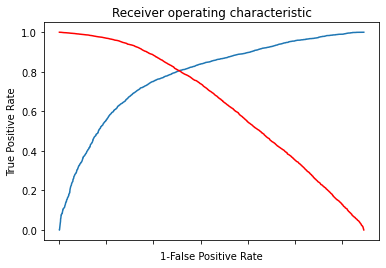

In [163]:
tpr = tpr_test
fpr = fpr_test

thresholds = thresholds_test
get_optimal_cutoff(tpr, fpr, thresholds)

In [164]:
threshold = 0.189765 #bisa dipilih terserah kita, tapi di atas ketemu optimumnya berapa

y_pred_train = np.where(yhat_train > threshold, 1, 0)
y_pred_test = np.where(yhat_test> threshold, 1, 0)

print(classification_report(y_test, 
                            y_pred_test))

              precision    recall  f1-score   support

           0       0.94      0.81      0.87      7598
           1       0.54      0.81      0.64      2127

    accuracy                           0.81      9725
   macro avg       0.74      0.81      0.76      9725
weighted avg       0.85      0.81      0.82      9725



In [171]:
from sklearn.utils.fixes import loguniform
from sklearn.linear_model import LogisticRegression  
from sklearn.model_selection import GridSearchCV

lr = LogisticRegression(random_state=SEED)

param_space = {
    "C": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000], #skala log, ini juga bisa pakai np.range
    "max_iter": [1000],
    "random_state": [SEED]
}

clf = GridSearchCV(lr, 
                   param_space, 
                   scoring='roc_auc', 
                   cv=4, 
                   refit=True)

In [172]:
clf.fit(X_train[all_features], y_train)

GridSearchCV(cv=4, estimator=LogisticRegression(random_state=42),
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'max_iter': [1000], 'random_state': [42]},
             scoring='roc_auc')

In [173]:
clf.best_params_

{'C': 1000, 'max_iter': 1000, 'random_state': 42}

In [174]:
model = LogisticRegression(random_state=SEED, max_iter=1000, C = 1000)
model.fit(X_train[all_features], y_train)

LogisticRegression(C=1000, max_iter=1000, random_state=42)

In [175]:
yhat_train = model.predict_proba(X_train[all_features])[:, 1]
yhat_test = model.predict_proba(X_test[all_features])[:, 1]

In [176]:
print("ROC-AUC Score Train:", roc_auc_score(y_train, yhat_train))
print("ROC-AUC Score Test:", roc_auc_score(y_test, yhat_test))

ROC-AUC Score Train: 0.8811588979851133
ROC-AUC Score Test: 0.8805695532922392


In [177]:
from sklearn.utils.fixes import loguniform
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(random_state=SEED)

param_space = {
    "n_estimators": [10,20,25],
    "max_depth": [2, 3, 4],
    "random_state": [SEED]
}

clf_rf = GridSearchCV(rf, 
                   param_space, 
                   scoring='roc_auc', 
                   cv=4, 
                   refit=True)

In [178]:
clf_rf.fit(X_train[all_features], y_train)

GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [2, 3, 4], 'n_estimators': [10, 20, 25],
                         'random_state': [42]},
             scoring='roc_auc')

In [179]:
clf_rf.best_params_

{'max_depth': 4, 'n_estimators': 25, 'random_state': 42}

In [180]:
modelrf = RandomForestClassifier(random_state=SEED, n_estimators=25, max_depth = 4)
modelrf.fit(X_train[all_features], y_train)

RandomForestClassifier(max_depth=4, n_estimators=25, random_state=42)

In [189]:
yhat_train = modelrf.predict_proba(X_train[all_features])[:,1]
yhat_test = modelrf.predict_proba(X_test[all_features])[:,1]

In [190]:
yhat_train

array([0.40599089, 0.12757667, 0.16162125, ..., 0.26601045, 0.086687  ,
       0.25193003])

In [ ]:
float(0.4059)

In [191]:
print("ROC-AUC Score Train RF:", roc_auc_score(y_train, yhat_train))
print("ROC-AUC Score Test RF:", roc_auc_score(y_test, yhat_test))

ROC-AUC Score Train RF: 0.881497644834114
ROC-AUC Score Test RF: 0.8809365181963977


dengan menggunakan random forest diperoleh hasil yang lebih bagus

In [192]:
import pickle 

#namanya bisa diubah kok
MODELNAME = 'Mei-RF-1.0.0.pkl'

with open(MODELNAME, 'wb') as f: # save model
    pickle.dump(modelrf, f)
    

In [193]:
data = pd.DataFrame(data)

In [194]:
data.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,...,loan_grade_F,loan_grade_G,cb_person_default_on_file_Y,person_age_WOE,loan_int_rate_WOE,loan_percent_income_WOE,person_income_WOE,loan_amnt_WOE,person_emp_length_WOE,cb_person_cred_hist_length_WOE
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,...,0,0,1,0.073,1.599,2.136,-0.302,0.707,-0.366,0.066
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,...,0,0,0,0.073,0.026,-0.742,3.065,-0.159,-0.225,0.066
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,...,0,0,0,0.073,0.026,2.136,3.065,-0.169,0.160,0.066
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,...,0,0,0,0.073,1.599,2.136,-0.302,0.707,0.160,0.066
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,...,0,0,1,0.073,0.026,2.136,-0.027,0.707,-0.225,0.031


In [195]:
X_train.loc[:, 'Risk'] = y_train
X_train.loc[:, 'score_proba'] = yhat_train
X_test.loc[:, 'Risk'] = y_test
X_test.loc[:, 'score_proba'] = yhat_test

In [196]:
X_train.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,...,cb_person_default_on_file_Y,person_age_WOE,loan_int_rate_WOE,loan_percent_income_WOE,person_income_WOE,loan_amnt_WOE,person_emp_length_WOE,cb_person_cred_hist_length_WOE,Risk,score_proba
7126,25,51684,MORTGAGE,9.0,PERSONAL,D,4000,15.99,0.08,N,...,0,0.073,1.599,-0.742,-0.027,-0.169,-0.225,0.031,0.0,0.405991
15645,22,90000,RENT,5.0,MEDICAL,B,15000,11.49,0.17,N,...,0,0.073,0.026,-0.279,-1.040,0.069,-0.225,0.031,0.0,0.127577
7626,24,93500,RENT,2.0,VENTURE,C,6400,13.23,0.07,Y,...,1,0.073,0.026,-0.742,-1.040,-0.169,0.160,0.066,0.0,0.161621
20390,27,49200,RENT,4.0,DEBTCONSOLIDATION,C,4800,14.65,0.10,N,...,0,-0.057,0.026,-0.742,-0.027,-0.169,0.160,-0.071,NaN,0.135246
7969,23,49000,MORTGAGE,7.0,MEDICAL,D,5000,15.21,0.10,N,...,0,0.073,1.599,-0.742,-0.027,-0.169,-0.225,0.066,1.0,0.501336


In [199]:
cek = X_train.sample(1).to_dict(orient = 'records')

In [200]:
cek

[{'person_age': 28,
  'person_income': 30000,
  'person_home_ownership': 'RENT',
  'person_emp_length': 0.0,
  'loan_intent': 'MEDICAL',
  'loan_grade': 'D',
  'loan_amnt': 11500,
  'loan_int_rate': 14.46,
  'loan_percent_income': 0.38,
  'cb_person_default_on_file': 'Y',
  'cb_person_cred_hist_length': 5,
  'person_home_ownership_OTHER': 0,
  'person_home_ownership_OWN': 0,
  'person_home_ownership_RENT': 1,
  'loan_intent_EDUCATION': 0,
  'loan_intent_HOMEIMPROVEMENT': 0,
  'loan_intent_MEDICAL': 1,
  'loan_intent_PERSONAL': 0,
  'loan_intent_VENTURE': 0,
  'loan_grade_B': 0,
  'loan_grade_C': 0,
  'loan_grade_D': 1,
  'loan_grade_E': 0,
  'loan_grade_F': 0,
  'loan_grade_G': 0,
  'cb_person_default_on_file_Y': 1,
  'person_age_WOE': -0.057,
  'loan_int_rate_WOE': 0.026,
  'loan_percent_income_WOE': 2.136,
  'person_income_WOE': 0.837,
  'loan_amnt_WOE': 0.069,
  'person_emp_length_WOE': 0.16,
  'cb_person_cred_hist_length_WOE': -0.071,
  'Risk': 0.0,
  'score_proba': 0.7462351777564

In [102]:
print(all_features)

['person_home_ownership_OTHER', 'person_home_ownership_OWN', 'person_home_ownership_RENT', 'loan_intent_EDUCATION', 'loan_intent_HOMEIMPROVEMENT', 'loan_intent_MEDICAL', 'loan_intent_PERSONAL', 'loan_intent_VENTURE', 'loan_grade_B', 'loan_grade_C', 'loan_grade_D', 'loan_grade_E', 'loan_grade_F', 'loan_grade_G', 'cb_person_default_on_file_Y', 'person_age_WOE', 'loan_int_rate_WOE', 'loan_percent_income_WOE', 'person_income_WOE', 'loan_amnt_WOE', 'person_emp_length_WOE', 'cb_person_cred_hist_length_WOE']
